In [ ]:
#import necessary library
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

#drive's local file
sorbian_path = '/content/drive/MyDrive/Colab Notebooks/train.hsb-de.hsb'
german_path = '/content/drive/MyDrive/Colab Notebooks/train.hsb-de.de'

#read hsb sentences
with open(sorbian_path, 'r', encoding='utf-8') as f:
    sorbian_sentences = f.readlines()

#read german sentences
with open(german_path, 'r', encoding='utf-8') as f:
    german_sentences = f.readlines()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

#dataset preprocess
def clean_and_align(sorbian_sentences, german_sentences, max_len=128):


    # Step 1: 清理空白和换行 remove empty sentences and /n
    sorbian_sentences = [s.strip() for s in sorbian_sentences if s.strip()]
    german_sentences = [s.strip() for s in german_sentences if s.strip()]

    # Step 2: 保持长度一致 keep align
    min_len = min(len(sorbian_sentences), len(german_sentences))
    sorbian_sentences = sorbian_sentences[:min_len]
    german_sentences = german_sentences[:min_len]

    # Step 3: 构建句对，过滤掉太长的句子 limitation of length of sentences
    filtered_pairs = []
    for s, g in zip(sorbian_sentences, german_sentences):
        if len(s.split()) < max_len and len(g.split()) < max_len:
            filtered_pairs.append((s, g))

    # Step 4: 去重（以句对为单位）remove duplicate sentences
    seen = set()
    unique_pairs = []
    for pair in filtered_pairs:
        if pair not in seen:
            seen.add(pair)
            unique_pairs.append(pair)

    # Step 5: 拆分成两个 list
    sorbian_clean, german_clean = zip(*unique_pairs) if unique_pairs else ([], [])

    return list(sorbian_clean), list(german_clean)

sorbian_sentences, german_sentences = clean_and_align(sorbian_sentences, german_sentences)

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('sentence-transformers/LaBSE')

# 分别生成两个语言的嵌入 generate embedding vectors
hsb_embeddings = model.encode(sorbian_sentences, show_progress_bar=True, batch_size=64)
np.save("/content/drive/MyDrive/Colab Notebooks/labse_hsb.npy", hsb_embeddings)
de_embeddings = model.encode(german_sentences, show_progress_bar=True, batch_size=64)
np.save("/content/drive/MyDrive/Colab Notebooks/labse_de.npy", de_embeddings)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
!pip install kneed


In [ ]:
# 聚类 + 可视化 cluster + visualization
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from kneed import KneeLocator


drive.mount('/content/drive')

#使用 Elbow 方法选择最佳聚类数（K）
#Use Elbow and kneedle methods to select optimal number of clusters (K)
#silhouette score is not fitted cuz dataset too big-> running too long
def elbow_with_kneedle(embeddings: np.ndarray, k_range=range(2, 21), title="Elbow Curve with Auto K Detection") -> int:
    """
    使用 inertia 曲线 + Kneedle 方法自动检测最佳聚类数 K。
    Elbow method + KneeLocator to auto-detect best K.
    """
    inertias = []
    print("start calculating KMeans different K value under inertia...")
    for k in k_range:
        print(f"Fitting KMeans for k={k}")
        kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
        inertias.append(kmeans.inertia_)

    # 自动检测“肘部”点  detect elbow point
    kneedle = KneeLocator(k_range, inertias, curve="convex", direction="decreasing")
    best_k = kneedle.elbow

    # 可视化 Elbow 曲线 plot elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertias, 'bo-', label="Inertia")
    if best_k:
        plt.axvline(x=best_k, color='red', linestyle='--', label=f"Best K = {best_k}")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Inertia")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.xticks(list(k_range))
    plt.show()

    if best_k:
        print(f"best K: {best_k}")
    else:
        print("no clear elbow found")

    return best_k

#kmeans方法用最佳的k值 kmeans using opimal k
def perform_kmeans(embeddings, n_clusters):
    print("Clustering in progress...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    print("Clustering completed.")
    return labels

#用pca降维画图 reduce high dimensions to low using PCA
def plot_clusters_pca(embeddings, labels, title):
    print("Running PCA dimensionality reduction...")
    pca = PCA(n_components=2, svd_solver='randomized', random_state=42)
    reduced = pca.fit_transform(embeddings)
    print("PCA completed. Generating plot...")

    # 可视化 visualization
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.colorbar(scatter)
    plt.show()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Clustering in progress...
Clustering completed.
Running PCA dimensionality reduction...
PCA completed. Generating plot...


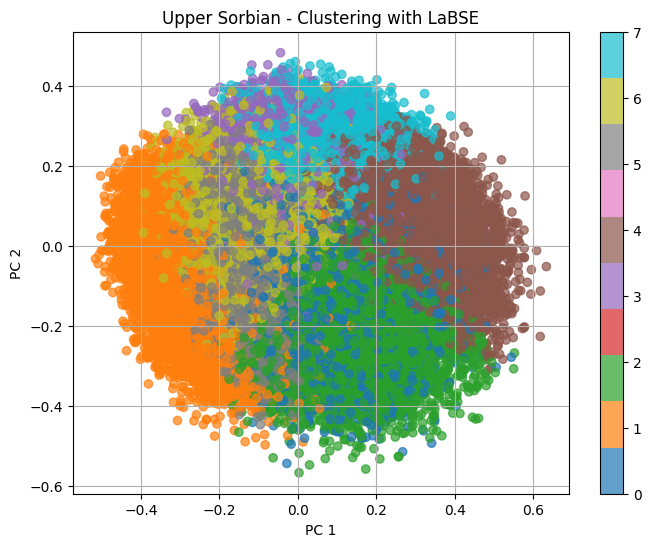

In [ ]:

# 加载保存好的嵌入向量 Load pre-saved sentence embeddings
hsb_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_hsb.npy")  # Upper Sorbian


# 判断最佳K determine optimal k--uppersobian
# 8 is the best k after running
# best_k_hsb = elbow_with_kneedle(hsb_embeddings, k_range=range(1, 25))
best_k_hsb = 8
# 聚类 cluster
hsb_labels = perform_kmeans(hsb_embeddings, n_clusters=best_k_hsb)

# 可视化 visualization
plot_clusters_pca(hsb_embeddings, hsb_labels, "Upper Sorbian - Clustering with LaBSE")


Clustering in progress...
Clustering completed.
Running PCA dimensionality reduction...
PCA completed. Generating plot...


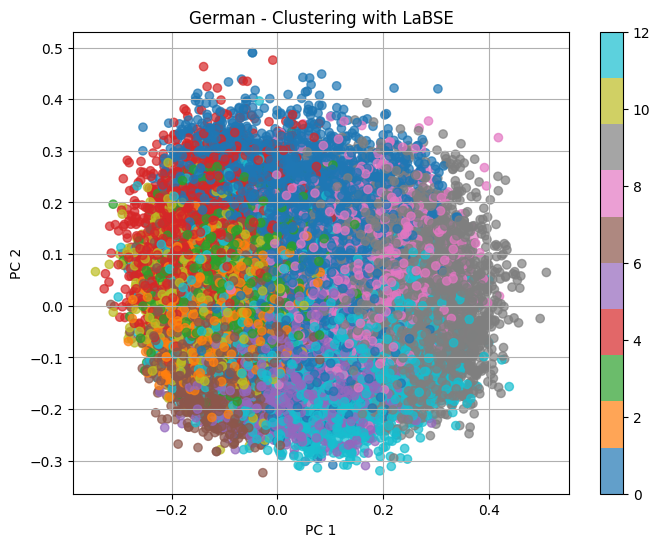

In [ ]:
de_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/labse/labse_de.npy")    # German

# de
# 13 is the best k after running
#best_k_de = elbow_with_kneedle(de_embeddings, k_range=range(1, 25))
best_k_de = 13
de_labels = perform_kmeans(de_embeddings, n_clusters=best_k_de)

plot_clusters_pca(de_embeddings, de_labels, "German - Clustering with LaBSE")

question: check the clusters that you have found to see if the found topic are consistent or not: do they talk about the same kind of theme? What do they have in common?

What I‘m doing: assigning topic labels to each cluster based on top frequent words.

Problem encountered:
- Most frequent words extracted (e.g., "und", "je", "a") are stopwords or grammatical particles.
- Creating a full stopword list manually?

What I’ve done:
- For each cluster, I’ve selected five representative sentences.
- Manually reviewed them to assess semantic consistency.


In [ ]:
from collections import defaultdict, Counter

# 将句子根据聚类标签分组 返回k个组 classify sentences by cluster number
def group_sentences_by_cluster(sentences, labels):
    clusters = defaultdict(list)
    for i, label in enumerate(labels):
        clusters[label].append(sentences[i])
    return clusters

# 根据高频词自动分配主题标签 name cluster using high-frequency words
def auto_assign_cluster_topics(keywords: dict):
    topic_labels = {}
    for cluster_id, word_freqs in keywords.items():
        label = word_freqs[0][0] if word_freqs else "Unknown"
        topic_labels[cluster_id] = label
    return topic_labels

# ✅ 主函数：构建每个 cluster 的“主题 + 示例句子”结构
def build_cluster_summary(sentences, labels, samples_per_cluster=5):
    """
    构建一个聚类摘要，包括主题标签和样本句子
    Build cluster summary: topic label + representative sentences
    输入：
      - sentences: 原始句子列表（与 labels 对应）
      - labels: 每个句子的聚类标签
      - samples_per_cluster: 每个 cluster 输出几个句子样本
    输出：
      - summary: dict[cluster_id] -> {topic, samples}
    """
    # 分组句子
    clusters = group_sentences_by_cluster(sentences, labels)

    # 统计关键词（每个 cluster 的 top 10）count top 10 word per cluster
    keywords = {}
    for cluster_id, sents in clusters.items():
        all_words = " ".join(sents).lower().split()
        keywords[cluster_id] = Counter(all_words).most_common(10)

    # 自动生成主题标签 generate labels
    topic_labels = auto_assign_cluster_topics(keywords)

    # 构建最终输出字典
    summary = {}
    for cluster_id in clusters:
        summary[cluster_id] = {
            "topic": topic_labels[cluster_id],
            "samples": clusters[cluster_id][:samples_per_cluster]
        }

    return summary


In [ ]:
summary = build_cluster_summary(sorbian_sentences, hsb_labels)

for cid, info in summary.items():
    print(f"\nCluster {cid} → Topic: {info['topic']}")
    for s in info['samples']:
        print("  ·", s)



Cluster 4 → Topic: je
  · Pos spi za durjemi.

  · Bórze je adwent zaso tu.

  · Rady chcemy dźěło z Wami dale pohłubšić.

  · Mje su prosće sakskemu kralej předali.

  · Dwanaćo běchu, su a přeco wostanu.


Cluster 6 → Topic: a
  · To je minimalna suma za start projekta.

  · Doskónčne dorozumjenje stanje so na posedźenju 17.06.2015.

  · Čłonojo towarstwa organizuja čitanja, koncerty, wustajeńcy a podobne.

  · Bóh je mi dał rosć w kraju mojeho hubjenstwa.

  · Tutón cyrkwinski zakoń, kotryž ma so w němskej a hornjoserbskej rěči wozjewić, nabudźe z 1. januarom 2003 płaćiwosć.


Cluster 5 → Topic: a
  · Za dobre zhromadne dźěło w knježerstwje njeje spomóžne stajnje na swoju wulkosć skedźbnjeć, Träger podšmórny.

  · Wona wudźěla slědźerske nadawki a organizuje dalše naprawy, kiž so jej k docpěću swojich zaměrow přihódne zdadźa.

  · Smy spytali, wšitke mocy koncentrować a towarstwa do skupinow Domowiny z wosobinskim sobustawstwom přeměnić.

  · To stej na přikład turistiski běrow w k

In [ ]:
summary = build_cluster_summary(german_sentences, de_labels)

for cid, info in summary.items():
    print(f"\nCluster {cid} → Topic: {info['topic']}")
    for s in info['samples']:
        print("  ·", s)


Cluster 4 → Topic: die
  · Der Hund schläft hinter der Türe.

  · Bald ist der Advent wieder da.

  · Die Mühlroser wissen, wovon ich rede.

  · Im Nest liegen Eier.

  · Unsere Antenne am Auto wird automatisch eingezogen.


Cluster 2 → Topic: die
  · Das ist die Mindestsumme für den Start des Projekts.

  · Aber in der Nacht zu angeln hat Vorteile, sagen die Angler selbst.

  · So machen wir das schon seit Jahren bei den Passionsspielen, erläutert er.

  · Das ist eigentlich eine gute Frage.

  · Für das Turnier sind 90 000 Euro vorgesehen.


Cluster 0 → Topic: die
  · Für eine gute Zusammenarbeit in der Regierung ist es nicht zuträglich immer auf die eigene Größe hinzuweisen, unterstrich Träger.

  · Gern möchten wir die Arbeit mit Ihnen weiter vertiefen.

  · Sie erteilt Forschungsaufträge und organisiert weitere Maßnahmen, welche zur Erreichung ihrer Ziele förderlich erscheinen.

  · Eine abschließende Verständigung soll in der Sitzung am 17.06.2015 erfolgen.

  · Gemeinsam mit Ih

Question: are sentences from one cluster in Upper Sorbian still in one cluster in German?

In [ ]:
from collections import defaultdict, Counter

def compare_cross_lingual_cluster_consistency(hsb_labels, de_labels, hsb_sentences, de_sentences):
    """
    比较 Upper Sorbian 的每个聚类中句子在 German 中的聚类分布。
    Compare how consistently each Upper Sorbian cluster maps into German clusters.
    返回：
    - report: dict — 每个 Upper Sorbian cluster 的映射分析，包括：
        - 映射最多的 German cluster ID
        - 一致性占比（百分比形式）
        - 各个 German cluster 的分布统计
     Returns:
    - report: dict — mapping statistics per Upper Sorbian cluster:
        - 'top_german_cluster': the German cluster with the most aligned sentences
        - 'consistency_ratio': proportion of sentences in that dominant cluster
        - 'distribution': full count of how aligned sentences are distributed across German clusters
    """
    cluster_map = defaultdict(list)  # 存储：Upper Sorbian cluster_id -> index列表
                                     # save：Upper Sorbian cluster_id -> index list
    for idx, label in enumerate(hsb_labels):
        cluster_map[label].append(idx)

    report = {}

    for cluster_id, indices in cluster_map.items():
        # 找出对应德语句子的聚类标签 find cluster of corresponding german sentences
        german_cluster_ids = [de_labels[i] for i in indices]
        german_counts = Counter(german_cluster_ids)
        total = len(german_cluster_ids)

        # 找到最常出现的 German cluster（占比最高）find most common cluster
        top_cluster, top_count = german_counts.most_common(1)[0]
        ratio = top_count / total

        # 构建报告
        report[cluster_id] = {
            "top_german_cluster": top_cluster,
            "consistency_ratio": round(ratio, 2),
            "distribution": dict(german_counts),

        }

    return report
def describe_crosslingual_cluster_mapping(report: dict):
    """
    输出 Upper Sorbian 每个聚类在 German 中的聚类分布描述（用于人类阅读）
    Print human-readable description of how each Upper Sorbian cluster maps to German clusters

    参数：
    - report: dict，来自 compare_cross_lingual_cluster_consistency() 的输出

    功能：
    - 不强调 cluster ID 的语义一致性
    - 更清楚地表述“映射到了哪个 German cluster（占比多少）”
    - 显示每个分布（distribution）、Upper Sorbian 示例句、德语翻译对照句
    """
    for cid, info in sorted(report.items()):
        print(f"\n Upper Sorbian Cluster {cid}:")
        print(f"  → Most mapped to German Cluster {info['top_german_cluster']} "
              f"({info['consistency_ratio']*100:.1f}% of sentences)")
        print(f"  → Full German cluster distribution: {info['distribution']}")



In [ ]:
report = compare_cross_lingual_cluster_consistency(hsb_labels, de_labels, sorbian_sentences, german_sentences)
describe_crosslingual_cluster_mapping(report)  # 用更合理语言描述映射结果



 Upper Sorbian Cluster 0:
  → Most mapped to German Cluster 10 (20.0% of sentences)
  → Full German cluster distribution: {np.int32(2): 1049, np.int32(3): 1275, np.int32(1): 235, np.int32(10): 1439, np.int32(4): 180, np.int32(7): 221, np.int32(5): 638, np.int32(0): 983, np.int32(12): 563, np.int32(11): 317, np.int32(8): 114, np.int32(9): 44, np.int32(6): 13}

 Upper Sorbian Cluster 1:
  → Most mapped to German Cluster 9 (60.0% of sentences)
  → Full German cluster distribution: {np.int32(9): 4386, np.int32(11): 770, np.int32(0): 225, np.int32(8): 910, np.int32(1): 531, np.int32(5): 217, np.int32(3): 94, np.int32(7): 31, np.int32(4): 56, np.int32(2): 35, np.int32(6): 19, np.int32(10): 32, np.int32(12): 39}

 Upper Sorbian Cluster 2:
  → Most mapped to German Cluster 0 (19.0% of sentences)
  → Full German cluster distribution: {np.int32(3): 1455, np.int32(0): 1728, np.int32(4): 519, np.int32(1): 1697, np.int32(5): 418, np.int32(2): 1217, np.int32(11): 723, np.int32(8): 879, np.int32(9):